In [24]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras

TensorFlow version: 2.9.1


In [25]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np

## Loading a dataset

## Split into train data and test data as dataset
- データセットとして使用するデータを取得する。
- trainデータとtestデータに分割する。（例えば80%をtrainデータに、20%をtestデータに、など。）
- 書き方はデータセットとして使用するデータの type による。もし、numpy の形で持っているならhttps://www.tensorflow.org/tutorials/load_data/numpy?hl=ja が参考になります。

In [26]:
# x_fullPath = os.path.abspath('x.npy')
x_fullPath = os.path.abspath('../../data/npy/x1.npy')
x_path = tf.keras.utils.get_file('x1.npy', 'file://'+x_fullPath)
# x_fullPath = os.path.abspath('../../data/npy/x2.npy')
# x_path = tf.keras.utils.get_file('x2.npy', 'file://'+x_fullPath)
# x_data = np.load(myarray_path)
x_data = np.load(x_path)

y_fullPath = os.path.abspath('../../data/npy/y.npy')
y_path = tf.keras.utils.get_file('y.npy', 'file://'+y_fullPath)
y_data = np.load(y_path)


# x_train, x_test, y_train, y_test = train_test_split(myarray_data, mc_data, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

# expected shape=(None, 118, 28560)
# x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
# x_test = np.reshape(x_test, (x_test.shape[0], 1,x_test.shape[1]))
# x_train = np.reshape(x_train, (1, x_train.shape[0], x_train.shape[1]))
# x_test = np.reshape(x_test, (1, x_test.shape[0], x_test.shape[1]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(len(x_train), 'train examples')
print(len(x_test), 'test examples')
print(len(y_train), 'train examples')


(94, 28560)
(24, 28560)
(94,)
(24,)
94 train examples
24 test examples
94 train examples


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-l10n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [27]:
def build_model():
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28560,)),
    tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [28]:
model = build_model()

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 28560)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3655808   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,655,937
Trainable params: 3,655,937
Non-trainable params: 0
_________________________________________________________________


In [30]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 28560)
1/1 [==============================] - 0s 261ms/step


In [31]:
print(example_result)

[[ 0.00223055]
 [-0.02128137]
 [-0.02742941]
 [-0.07071103]
 [-0.02522076]
 [-0.00794134]
 [ 0.00223055]
 [ 0.06525075]
 [-0.00794134]
 [-0.00794134]]


In [32]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# EPOCHS = 400 # epoch 数も考慮しよう
EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,13.894257,1.890465,13.894257,8.156272,1.567921,8.156272,95
96,19.761271,2.376363,19.761271,7.746706,1.533442,7.746706,96
97,10.748694,1.716617,10.748694,7.456765,1.487803,7.456765,97
98,13.118937,2.034664,13.118937,7.224368,1.544842,7.224368,98
99,11.939605,1.804279,11.939605,6.956187,1.530323,6.956187,99


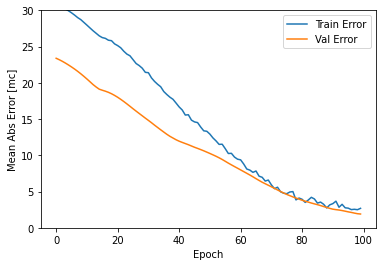

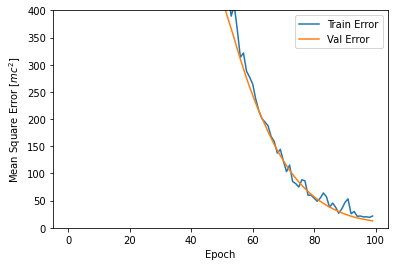

In [33]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,400])
    plt.legend()
    plt.show()


plot_history(history)

1/1 [==============================] - 0s 57ms/step


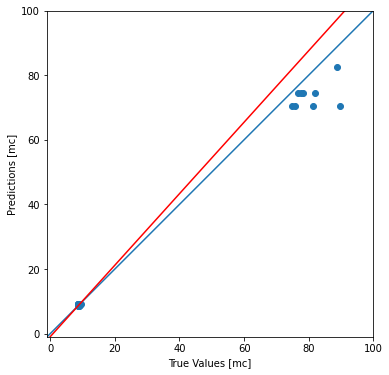

In [34]:
test_predictions = model.predict(x_test).flatten()
res = linregress(test_predictions, y_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mc]')
plt.ylabel('Predictions [mc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-1,100])
plt.ylim([-1,100])
_ = plt.plot([-100, 100], [-100, 100])

plt.plot([-1, 100], res.intercept + res.slope*np.array([-1, 100]), 'r', label='fitted line')

In [36]:
# トレーニングした model をどこかで使用したいなら以下のようにモデルを保存する
model.save('saved_model/x1_model')

INFO:tensorflow:Assets written to: saved_model/x1_model/assets
